# Re-Generating Candlestick Data

Since our previous attempt at generating candlestick data didn't work out too well, we extracted new information and metrics from the real historical stock data that *should* help generate more realistic data.

We are essentially going to perform the same tasks that we performed in `stock_journal_06` but with the new data. Finger's crossed this works out.

The main differences will take place in the function that handles the generation itself. These first few cells will be used for acquiring usable information from the distributions for generation.

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
real_p_changes = pd.read_csv('analytics/candlestick_metrics.csv')

real_p_changes.head()

,Color,next_color,close_to_next_change,change_open_close,high_change,low_change
0,r,g,0.356497,-0.104432,0.924046,-0.490403
1,g,g,-0.477417,1.987418,0.242152,-0.014631
2,g,r,-1.256556,0.809507,0.457553,-0.386880
3,r,r,-0.078195,-1.447637,0.375039,-0.552576
4,r,g,0.730388,-0.171289,0.152772,-0.917043


In [16]:
green_data = real_p_changes[real_p_changes['Color'] == 'g']
red_data = real_p_changes[real_p_changes['Color'] == 'r']

gg_changes = green_data[green_data['next_color'] == 'g']['close_to_next_change']
gr_changes = green_data[green_data['next_color'] == 'r']['close_to_next_change']
rg_changes = green_data[green_data['next_color'] == 'g']['close_to_next_change']
rr_changes = green_data[green_data['next_color'] == 'r']['close_to_next_change']

color_dists = [gg_changes, gr_changes, rg_changes, rr_changes]

g_high = green_data['high_change']
g_low = green_data['low_change']
g_hl = [g_high, g_low]

r_high = red_data['high_change']
r_low = red_data['low_change']
r_hl = [r_high, r_low]

g_oc = green_data['change_open_close']
r_oc = red_data['change_open_close']

In [11]:
from data_gen import custom_sample_distribution

color_dist_labels = ['gg_changes', 'gr_changes', 'rg_changes', 'rr_changes']

color_dist_samples = []

for dist in color_dists:
    dist_values, dist_probs = custom_sample_distribution(dist);
    color_dist_samples.append([dist_values, dist_probs])

color_dist_samples = np.asarray(color_dist_samples)

print(color_dist_samples.shape)

(4, 2, 500)


In [24]:
g_hl_dists = []
r_hl_dists = []

for dist in g_hl:
    dist_values, dist_probs = custom_sample_distribution(dist);
    g_hl_dists.append([dist_values, dist_probs])

g_hl_dists = np.asarray(g_hl_dists)


for dist in r_hl:
    dist_values, dist_probs = custom_sample_distribution(dist);
    r_hl_dists.append([dist_values, dist_probs])

r_hl_dists = np.asarray(r_hl_dists)

print(g_hl_dists.shape)
print(r_hl_dists.shape)

highs_lows = np.asarray([g_hl_dists, r_hl_dists])

print(highs_lows.shape)


(2, 2, 500)
(2, 2, 500)
(2, 2, 2, 500)
(2, 2, 500)


In [27]:
print(highs_lows[1].shape)
print(highs_lows[0][0][1])

(2, 2, 500)
[0.01163921 0.00788336 0.00741374 0.00705286 0.00664545 0.00667742
 0.00616026 0.00560731 0.00531903 0.00498779 0.00448379 0.00423697
 0.00378334 0.00372927 0.0032573  0.00315576 0.00304568 0.00295357
 0.00279903 0.00262976 0.00258473 0.00247311 0.00244244 0.00237997
 0.00230136 0.00229915 0.00219354 0.00219354 0.00214359 0.00217467
 0.00216219 0.00211702 0.00208676 0.00206089 0.00205102 0.00202365
 0.00200048 0.00201977 0.0020101  0.00197189 0.00196434 0.00197
 0.0019344  0.00196811 0.00195118 0.0019344  0.00191961 0.00195681
 0.00191961 0.00189945 0.0019031  0.00189399 0.00191042 0.00190859
 0.00189581 0.0019031  0.00189036 0.00189036 0.00187231 0.00189218
 0.00189218 0.00187051 0.0018759  0.00188674 0.00187951 0.00187951
 0.0018759  0.0018759  0.0018777  0.00186692 0.00186692 0.00186334
 0.0018741  0.00187051 0.00186513 0.00185977 0.00186692 0.00185977
 0.00186156 0.00186692 0.00187051 0.00185799 0.00186513 0.00186692
 0.00186692 0.00185977 0.00185442 0.00186156 0.001856

In [13]:
oc_dists = []

dist_values, dist_probs = custom_sample_distribution(g_oc)
oc_dists.append([dist_values, dist_probs])

dist_values, dist_probs = custom_sample_distribution(r_oc)
oc_dists.append([dist_values, dist_probs])

oc_dists = np.asarray(oc_dists)

oc_dists.shape

(2, 2, 500)

Now that we have all of these components, the tricky part is going to be putting it all together. I am going to try and retain the moving volitility to the best of my ability, though it is likely that it gets dropped.

In [446]:
from datetime import timedelta

from data_gen import gen_new_val

volitility = 0.01
body_modifier = 0.5
shadow_modifier = 1.5

def determine_color_seq_num(prev_color, next_color):
    if prev_color == 0:
        if next_color == 0: return 0
        else: return 1
    else:
        if next_color == 0: return 2
        else: return 3

def gen_new_values(previous_close, color_dists, oc_dists, hl_dist, color_seq_ind, new_color_ind):
    percentage_change = np.random.choice(a=color_dists[color_seq_ind][0], p=color_dists[color_seq_ind][1]) * volitility
    
    # Generate new Open based on previous Close
    new_open = gen_new_val(previous_close, percentage_change) 
    
    # Calculate the change from Open to Close
    oc_change = np.random.choice(a=oc_dists[new_color_ind][0], p=oc_dists[new_color_ind][1]) * body_modifier
    new_close = gen_new_val(new_open, oc_change)
    

    high_change = np.random.choice(a=hl_dist[new_color_ind][0][0], p=hl_dist[new_color_ind][0][1]) * shadow_modifier
    low_change = np.random.choice(a=hl_dist[new_color_ind][1][0], p=hl_dist[new_color_ind][1][1]) * shadow_modifier

    # If for green day (high off Close, low off Open)
    if new_color_ind == 0:
        new_high = gen_new_val(new_close, high_change)
        new_low = gen_new_val(new_open, low_change)
    # If for red day (high off Open, low off Close)
    else:
        new_high = gen_new_val(new_open, high_change)
        new_low = gen_new_val(new_close, low_change)

    return (new_open, new_close, new_high, new_low)


def generate_data(numVals, volatility, color_dists, highs_lows, opens_closes,
                  init_val=1, moving_vol=True, random_seed=42):
    
    
    # np.random.seed(random_seed)

    color_choices = [0, 1]
    color_p = [0.5, 0.5]

    prev_color = 0
    next_color = 0

    stock_colors = ['g']

    color_seq_id = determine_color_seq_num(prev_color, next_color)
    new_values = gen_new_values(init_val, color_dists, opens_closes, highs_lows, color_seq_id, next_color)

    opens, closes = [new_values[0]], [new_values[1]]
    highs, lows = [new_values[2]], [new_values[3]]


    for x in range(numVals):
        previous_close = closes[x]
        next_color = np.random.choice(a=color_choices, p=color_p)
        color_seq_id = determine_color_seq_num(prev_color, next_color)

        new_values = gen_new_values(previous_close, color_dists, opens_closes, highs_lows, color_seq_id, next_color)

        opens.append(new_values[0])
        closes.append(new_values[1])
        highs.append(new_values[2])
        lows.append(new_values[3])

        if next_color == 0:
            stock_colors.append('g')
        else:
            stock_colors.append('r')

        prev_color = next_color


    start_date = '1998-03-22'
    end_date = pd.to_datetime(start_date) + timedelta(days=numVals)

    dates = pd.date_range(start_date, end_date)
    
    data = [opens, highs, lows, closes]
    data = np.array(data).T.astype(float)

    stock_data = pd.DataFrame(data=data, columns=['Open', 'High', 'Low', 'Close'], index=dates)
    stock_data['Color'] = stock_colors

    return stock_data

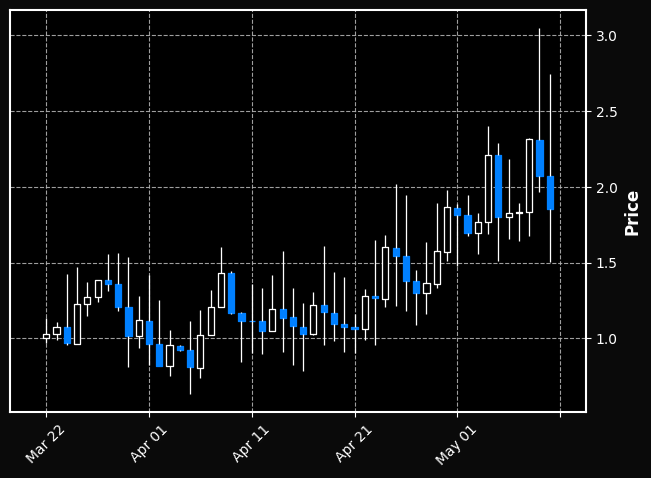

In [499]:
import mplfinance as fplt

volitility = 0.01 ** 1/3
body_modifier = 1.1
shadow_modifier = 1.02 ** 0.3

np.random.seed()
seed = int(np.random.random())

fake_data = generate_data(100, 0, color_dist_samples, highs_lows, oc_dists, 1, False, seed)
fake_ochl = fake_data[['Open', 'High', 'Low', 'Close']]

fplt.plot(fake_ochl[:50], type='candle', style='mike')

In [89]:
fake_data.head(10)

,Open,High,Low,Close,Color
1998-03-22,0.999865,1.132359,0.983940,1.002878,g
1998-03-23,0.997037,1.201532,0.897293,1.037047,g
1998-03-24,1.035988,1.283875,0.984316,1.283326,g
1998-03-25,1.280341,1.378454,1.219822,1.232041,r
1998-03-26,1.228253,1.358067,0.970269,1.053258,r
1998-03-27,1.049425,1.329662,1.018087,1.207334,g
1998-03-28,1.207028,1.569272,0.914094,1.117993,r
1998-03-29,1.112380,1.331969,0.981369,1.134144,g
1998-03-30,1.130706,1.179018,1.078052,1.106712,r
1998-03-31,1.106380,1.399863,1.020924,1.179079,g
